In [1]:
# General imports
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Iterable, Any
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (18, 10)
plt.rcParams["figure.facecolor"] = "white"

# ML imports
import torch
from torch.utils import data
from torch import nn
import torch.nn.functional as F
import einops
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
import sklearn.manifold

# power_perceiver imports
from power_perceiver.dataset import NowcastingDataset
from power_perceiver.consts import BatchKey
from power_perceiver.data_loader import HRVSatellite, PV, Sun
from power_perceiver.xr_batch_processor import SelectPVSystemsNearCenterOfImage, ReduceNumPVSystems, ReduceNumTimesteps
from power_perceiver.np_batch_processor import EncodeSpaceTime
from power_perceiver.transforms.satellite import PatchSatellite
from power_perceiver.transforms.pv import PVPowerRollingWindow

/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#DATA_PATH = Path("~/dev/ocf/power_perceiver/data_for_testing/").expanduser()

DATA_PATH = Path(
    "/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15/")
assert DATA_PATH.exists()

In [3]:
def get_dataloader(data_path: Path, tag: str) -> data.DataLoader:
    assert tag in ["train", "validation"]
    assert data_path.exists()
    
    xr_batch_processors = [
        SelectPVSystemsNearCenterOfImage(),
        ReduceNumPVSystems(requested_num_pv_systems=8),
        ]
    
    if tag == "train":
        xr_batch_processors.append(ReduceNumTimesteps(requested_timesteps=4))
    
    dataset = NowcastingDataset(
        data_path=data_path,
        data_loaders=[
            HRVSatellite(
                transforms=[PatchSatellite()]
                ), 
            PV(
                transforms=[PVPowerRollingWindow()]
                ),
            Sun(),
        ],
        xr_batch_processors=xr_batch_processors,
        np_batch_processors=[EncodeSpaceTime()]
    )

    dataloader = data.DataLoader(
        dataset,
        batch_size=None,
        num_workers=16,
        pin_memory=True,
    )
    
    return dataloader

#train_dataloader = get_dataloader(DATA_PATH)
train_dataloader = get_dataloader(DATA_PATH / "train", tag="train")
val_dataloader = get_dataloader(DATA_PATH / "test", tag="validation")

In [4]:
for batch in train_dataloader:
    break

[15  5  4  6][15  5  4  6]

[15  5  4  6]
[15  5  4  6]
[15  5  4  6]
[15  5  4  6]
[15  5  4  6][15  5  4  6]

[15  5  4  6]
[15  5  4  6]
[15  5  4  6]
[15  5  4  6]
[15  5  4  6]
[15  5  4  6]
[15  5  4  6]
[15  5  4  6]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0][ 1 15 15  0]

[ 1 15 15  0]
[ 1 15 15  0]
[ 1 15 15  0]
[27 26 12 20]


In [5]:
batch[BatchKey.pv].shape

torch.Size([31, 4, 8])

In [6]:
batch[BatchKey.pv_time_utc].shape

torch.Size([31, 4])

In [7]:
class TransformerEncoderLayerForVisualisingWieghts(nn.TransformerEncoderLayer):
    def _sa_block(
            self, 
            x: torch.Tensor,
            attn_mask: Optional[torch.Tensor], 
            key_padding_mask: Optional[torch.Tensor]
        ) -> torch.Tensor:
        
        # The only change we make is to pass in all the parameters as
        # *positional* parameters (not keyword) so the forward_pre_hook
        # can access and modify them :)
        need_weights = False
        x = self.self_attn(x, x, x, key_padding_mask, need_weights, attn_mask)[0]
        return self.dropout1(x)


@dataclass(eq=False)
class MultiLayerTransformerEncoder(nn.Module):
    d_model: int
    num_heads: int = 8
    dropout: float = 0.0
    share_weights_across_latent_transformer_layers: bool = True
    num_latent_transformer_encoders: int = 4
    
    def __post_init__(self):
        super().__init__()

        # TransformerEncoderLayer is made up of self-attn and feedforward network.
        # This standard encoder layer is based on the paper “Attention Is All You Need”
        transformer_encoder_layer = TransformerEncoderLayerForVisualisingWieghts(
            d_model=self.d_model,
            nhead=self.num_heads,
            dropout=self.dropout,
            batch_first=True
        )

        if self.share_weights_across_latent_transformer_layers:
            transformer_encoder_layers = [transformer_encoder_layer] * self.num_latent_transformer_encoders
            self.transformer_encoder = nn.Sequential(*transformer_encoder_layers)
        else:
            self.transformer_encoder = nn.TransformerEncoder(
                encoder_layer=transformer_encoder_layer,
                num_layers=self.num_latent_transformer_encoders,
            )
            
    def forward(self, *args, **kwargs):
        return self.transformer_encoder(*args, **kwargs)


@dataclass(eq=False)  # See: https://discuss.pytorch.org/t/typeerror-unhashable-type-for-my-torch-nn-module/109424/6
class Perceiver(nn.Module):
    """
    Input and output tensors are provided as shape (batch, seq, feature).
    
    Init args:
        num_heads: Number of parallel attention heads. Note that ``embed_dim`` will be split
            across ``num_heads`` (i.e. each head will have dimension ``embed_dim // num_heads``).
        dropout: Dropout probability on ``attn_output_weights``. Default: ``0.0`` (no dropout).
    """
    query_dim: int
    byte_array_dim: int
    num_heads: int = 8
    dropout: float = 0.0
    share_weights_across_latent_transformer_layers: bool = True
    num_latent_transformer_encoders: int = 4
    
    def __post_init__(self):
        super().__init__()

        # Cross attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=self.query_dim,
            num_heads=self.num_heads,
            dropout=self.dropout,
            batch_first=True,
            kdim=self.byte_array_dim,
            vdim=self.byte_array_dim
        )
        
        self.latent_transformer = MultiLayerTransformerEncoder(
            d_model=self.query_dim, 
            num_heads=self.num_heads,
            dropout=self.dropout,
            share_weights_across_latent_transformer_layers=self.share_weights_across_latent_transformer_layers,
            num_latent_transformer_encoders=self.num_latent_transformer_encoders,
            )

    def forward(
            self, 
            query: torch.Tensor, 
            byte_array: torch.Tensor, 
            byte_array_padding_mask: Optional[torch.Tensor] = None
        ) -> torch.Tensor:
        """
        Args:
            query: Query embeddings of shape `(N, L, query_dim)`, where `N` is the batch size,
                and `L` is the number of query elements (the target sequence length).
                Queries are compared against key-value pairs to produce the output.
            byte_array: Key embeddings of shape `(N, S, byte_array_dim)`, where `N` is the batch size, 
                and `S` is the number of byte_array elements (the source sequence length).
            byte_array_padding_mask: If specified, a mask of shape `(N, S)` indicating which 
                elements within ``byte_array`` to ignore for the purpose of attention (i.e. treat as "padding").
                Shape should be `(N, S)`. Binary and byte masks are supported.
                For a binary mask, a ``True`` value indicates that the corresponding ``byte_array`` value
                will be ignored for the purpose of attention. For a byte mask, a non-zero value indicates
                that the corresponding ``byte_array`` value will be ignored.
                
        Returns:
            **attn_output** - Attention outputs of shape `(N, L, query_dim)`,
                where `N` is the batch size, and
                `L` is the number of query elements (the target sequence length).
        """
        attn_output, attn_weights = self.cross_attention(
            query=query, 
            key=byte_array, 
            value=byte_array, 
            need_weights=False,  # TODO: Plot attention weights.
            key_padding_mask=byte_array_padding_mask,
            )
        return self.latent_transformer(attn_output)

In [8]:
def repeat_over_time(
        x: dict[BatchKey, torch.Tensor],
        batch_keys: Iterable[BatchKey], 
        n_timesteps: int
    ) -> list[torch.Tensor]:
    repeated_tensors = []
    for batch_key in batch_keys:
        tensor = x[batch_key]
        tensor = einops.repeat(tensor, "batch_size ... -> batch_size time ...", time=n_timesteps)
        repeated_tensors.append(tensor)
    return repeated_tensors


class HRVSatelliteProcessor(nn.Module):
    def __post_init__(self):
        super().__init__()
    
    def forward(self, x: dict[BatchKey, torch.Tensor]) -> torch.Tensor:
        """Returns a byte array ready for Perceiver"""
        # Create the byte array
        # TODO:
        # Append the satellite position encoding onto the "patch" dimension.
        # Reshape the satellite imagery to the correct shape
        
        # Ignore the "channels" dimension because HRV is just a single channel:
        hrvsatellite = x[BatchKey.hrvsatellite][:, :, 0]
        
        # Repeat the fourier features for each timestep of each example:
        n_timesteps = hrvsatellite.shape[1]
        y_fourier, x_fourier = repeat_over_time(
            x=x, 
            batch_keys=(
                BatchKey.hrvsatellite_y_osgb_fourier, 
                BatchKey.hrvsatellite_x_osgb_fourier,
                ),
            n_timesteps=n_timesteps)
        # y_fourier and x_fourier are now of shape batch, time, y, x, n_fourier_features
        
        # Reshape solar features to: batch, time, y, x, 1
        def _repeat_solar_feature_over_x_and_y(solar_feature: torch.Tensor) -> torch.Tensor:
            return einops.repeat(
                solar_feature, 
                "batch time -> batch time y x 1", 
                y=hrvsatellite.shape[2],
                x=hrvsatellite.shape[3],
                )
        solar_azimuth = _repeat_solar_feature_over_x_and_y(x[BatchKey.solar_azimuth])
        solar_elevation = _repeat_solar_feature_over_x_and_y(x[BatchKey.solar_elevation])
        
        # Concatenate spatial fourier features and solar features onto satellite imagery:
        byte_array = torch.concat((hrvsatellite, y_fourier, x_fourier, solar_azimuth, solar_elevation), dim=-1)

        # Reshape so each timestep is seen as a separate example, and the 2D
        # image is flattened into a 1D array.
        byte_array = einops.rearrange(
            byte_array,
            "batch_size time y x feature -> (batch_size time) (y x) feature"
        )
        
        return byte_array
    
# Test!
HRVSatelliteProcessor()(batch).shape

torch.Size([124, 256, 34])

In [9]:
batch[BatchKey.pv].shape

torch.Size([31, 4, 8])

In [10]:
def masked_mean(tensor: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    # Adapted from https://discuss.pytorch.org/t/how-to-write-a-loss-function-with-mask/53461/4
    masked_tensor = torch.where(mask, tensor, torch.tensor(0, dtype=tensor.dtype, device=tensor.device))
    total = masked_tensor.sum()
    num_selected_elements = mask.sum()
    return total / num_selected_elements


@dataclass(eq=False)
class QueryGenerator(nn.Module):
    """Create a query using a learnt array and the locations of the PV systems."""
    num_fourier_features: int  # TOTAL (for both x and y)
    num_elements_query_padding: int
    pv_system_id_embedding_dim: int
    num_pv_systems: int = 2000  # TODO: Set this to the correct number!
    
    def __post_init__(self):
        super().__init__()
        # Plus two for solar azimuth and elevation
        self.query_dim = self.num_fourier_features + self.pv_system_id_embedding_dim + 2
        self.query_padding = nn.Parameter(
            torch.randn(self.num_elements_query_padding, self.query_dim) / 5)
        self.pv_system_id_embedding = nn.Embedding(
            num_embeddings=self.num_pv_systems,
            embedding_dim=self.pv_system_id_embedding_dim,
        )
        
    def forward(self, x: dict[BatchKey, torch.Tensor]) -> torch.Tensor:
        # Repeat the fourier features for each timestep of each example:
        n_timesteps = x[BatchKey.pv].shape[1]
        y_fourier, x_fourier, pv_system_row_number = repeat_over_time(
            x=x, 
            batch_keys=(BatchKey.pv_y_osgb_fourier, BatchKey.pv_x_osgb_fourier, BatchKey.pv_system_row_number),
            n_timesteps=n_timesteps)
        # y_fourier and x_fourier are now of shape (batch, time, n_pv_systems, n_fourier_features)
        
        # Reshape solar features to: batch, time, n_pv_systems, 1
        def _repeat_solar_feature_over_x_and_y(solar_feature: torch.Tensor) -> torch.Tensor:
            return einops.repeat(
                solar_feature, 
                "batch time -> batch time n_pv_systems 1", 
                n_pv_systems=x[BatchKey.pv_x_osgb].shape[1],
                )
        solar_azimuth = _repeat_solar_feature_over_x_and_y(x[BatchKey.solar_azimuth])
        solar_elevation = _repeat_solar_feature_over_x_and_y(x[BatchKey.solar_elevation])
        
        pv_system_embedding = self.pv_system_id_embedding(pv_system_row_number)
        
        pv_system_query = torch.concat(
            (y_fourier, x_fourier, pv_system_embedding, solar_azimuth, solar_elevation),
            dim=-1)
        del y_fourier, x_fourier, pv_system_embedding
        
        # Missing PV systems are represented as NaN in the fourier features. Fill these with zeros.
        # (We do this because we can't mask the *query*. Instead, we'll ignore missing PV
        # systems in the objective function.)
        pv_system_query = torch.nan_to_num(pv_system_query, nan=0.0)
        
        # Reshape so every timestep is a different example.
        pv_system_query = einops.rearrange(
            pv_system_query, 
            "batch_size time n_pv_systems query_dim -> (batch_size time) n_pv_systems query_dim",
            query_dim=self.query_dim,
            )

        # Repeat the learnt query padding for every example in the batch:
        batch_size = pv_system_query.shape[0]
        batched_query_padding = einops.repeat(
            self.query_padding, 
            "num_query_elements query_dim -> batch_size num_query_elements query_dim",
            batch_size=batch_size, query_dim=self.query_dim)
        query = torch.concat((batched_query_padding, pv_system_query), dim=1)
        return query


@dataclass(eq=False)  # See https://discuss.pytorch.org/t/typeerror-unhashable-type-for-my-torch-nn-module/109424/6
class Model(pl.LightningModule):
    # Params for Perceiver
    num_fourier_features: int = 16 # TOTAL for both x and y
    pv_system_id_embedding_dim: int = 16
    byte_array_dim: int = 34
    num_heads: int = 6
    dropout: float = 0.0
    share_weights_across_latent_transformer_layers: bool = False
    num_latent_transformer_encoders: int = 4
    num_zeros_to_pad: int = 2  # Quick hack to allow us to use more heads!
    
    # Other params:
    num_elements_query_padding: int = 0

    def __post_init__(self):
        super().__init__()
        self.hrvsatellite_processor = HRVSatelliteProcessor()
        
        self.query_generator = QueryGenerator(
            num_fourier_features=self.num_fourier_features,  # TOTAL (for both x and y)
            pv_system_id_embedding_dim=self.pv_system_id_embedding_dim,
            num_elements_query_padding=self.num_elements_query_padding)

        # While we're using the MultiLayerTransformerEncoder:
        assert self.query_generator.query_dim == self.byte_array_dim, f"{self.query_generator.query_dim=} != {self.byte_array_dim=}"
        
        self.query_dim = self.query_generator.query_dim + self.num_zeros_to_pad
        
        self.transformer_encoder = MultiLayerTransformerEncoder(
            d_model=self.query_dim, 
            num_heads=self.num_heads,
            dropout=self.dropout,
            share_weights_across_latent_transformer_layers=self.share_weights_across_latent_transformer_layers,
            num_latent_transformer_encoders=self.num_latent_transformer_encoders,
            )
        
        """
        self.perceiver = Perceiver(
            query_dim=self.query_dim,
            byte_array_dim=self.byte_array_dim,
            num_heads=self.num_heads,
            dropout=self.dropout,
            share_weights_across_latent_transformer_layers=self.share_weights_across_latent_transformer_layers,
            num_latent_transformer_encoders=self.num_latent_transformer_encoders,
            )
        """
        
        self.output_module = nn.Sequential(
            nn.Linear(in_features=self.query_dim, out_features=self.query_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.query_dim, out_features=1),
        )

        # Do this at the end of __post_init__ to capture model topology:
        self.save_hyperparameters()
        
    def forward(self, x: dict[BatchKey, torch.Tensor]) -> torch.Tensor:       
        original_batch_size = x[BatchKey.pv].shape[0]
        byte_array = self.hrvsatellite_processor(x)
        query = self.query_generator(x)
        
        attn_input = torch.concat((byte_array, query), dim=1)
        if self.num_zeros_to_pad:
            zero_padding_shape = attn_input.shape[:2] + (self.num_zeros_to_pad,)
            zero_padding = torch.zeros(
                *zero_padding_shape, 
                dtype=attn_input.dtype,
                device=attn_input.device,
                )
            attn_input = torch.concat((attn_input, zero_padding), dim=2)
        attn_output = self.transformer_encoder(attn_input)

        # Ignore first num_elements_query_padding elements of the output.
        out = attn_output[:, byte_array.shape[1]:]
        
        out = self.output_module(out)
        
        # Reshape back to (batch_size, n_timesteps, ...)
        return einops.rearrange(
            out, 
            "(batch_size n_timesteps) ... -> batch_size n_timesteps ...", 
            batch_size=original_batch_size)
    
    def _training_or_validation_step(
            self, 
            batch: dict[BatchKey, torch.Tensor], 
            batch_idx: int, 
            tag: str
        ) -> dict[str, object]:
        """
        Args:
            batch: The training or validation batch.  A dictionary.
            tag: Either "train" or "validation"
            batch_idx: The index of the batch.
        """
        actual_pv_power = batch[BatchKey.pv]
        #actual_pv_power = torch.nan_to_num(actual_pv_power, nan=0.0)
        actual_pv_power = torch.where(
            batch[BatchKey.pv_mask].unsqueeze(1), 
            actual_pv_power, 
            torch.tensor(0.0, dtype=actual_pv_power.dtype, device=actual_pv_power.device))

        predicted_pv_power = self(batch).squeeze()
        #mse_loss = F.mse_loss(predicted_pv_power, actual_pv_power, reduction="none").mean(dim=1).float()
        #mse_loss = masked_mean(mse_loss, mask=batch[BatchKey.pv_mask])        
        mse_loss = F.mse_loss(predicted_pv_power, actual_pv_power)
        
        self.log(f"{tag}/mse", mse_loss)
        
        return {
            'loss': mse_loss,
            'predicted_pv_power': predicted_pv_power,
            }
    
    def training_step(self, batch: dict[BatchKey, torch.Tensor], batch_idx: int) -> dict[str, object]:
        return self._training_or_validation_step(batch=batch, batch_idx=batch_idx, tag="train")
    
    def validation_step(self, batch: dict[BatchKey, torch.Tensor], batch_idx: int) -> dict[str, object]:
        return self._training_or_validation_step(batch=batch, batch_idx=batch_idx, tag="validation")
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [11]:
class CustomCallback(pl.Callback):
    def on_train_batch_end(
            self,
            trainer: pl.Trainer,
            pl_module: pl.LightningModule,
            outputs: Optional[dict[str, object]],
            batch: Any,
            batch_idx: int,
            dataloader_idx: int,
        ) -> None:
        self._on_batch_end(
            trainer=trainer, pl_module=pl_module, outputs=outputs, batch=batch, 
            batch_idx=batch_idx, dataloader_idx=dataloader_idx, tag="train")

    def on_validation_batch_end(
            self,
            trainer: pl.Trainer,
            pl_module: pl.LightningModule,
            outputs: Optional[dict[str, object]],
            batch: Any,
            batch_idx: int,
            dataloader_idx: int,
        ) -> None:
        self._on_batch_end(
            trainer=trainer, pl_module=pl_module, outputs=outputs, batch=batch, 
            batch_idx=batch_idx, dataloader_idx=dataloader_idx, tag="validation")

In [12]:
import pandas as pd

def plot_pv_power(
        actual_pv_power: torch.Tensor,
        predicted_pv_power: torch.Tensor,
        example_idx: int,
        datetimes: torch.Tensor,
    ) -> plt.Figure:
    fig, (ax_actual, ax_predicted) = plt.subplots(nrows=2, sharex=True)
    
    datetimes = pd.to_datetime(datetimes[example_idx], unit="s")
    
    def _plot(ax, data, title):
        ax.plot(datetimes, data[example_idx].squeeze())
        ax.set_title(title)    
        ax.set_ylabel("PV power")
        ax.set_xlabel("Timestep")                
    
    _plot(ax_actual, actual_pv_power, "Actual PV power")
    _plot(ax_predicted, predicted_pv_power, "Predicted PV power")
    
    return fig


class LogTimeseriesPlots(CustomCallback):
    def _on_batch_end(
            self,
            trainer: pl.Trainer,
            pl_module: pl.LightningModule,
            outputs: Optional[dict[str, object]],
            batch: Any,
            batch_idx: int,
            dataloader_idx: int,
            tag: str,
        ) -> None:
        """Called when the training batch ends.
        
        Args:
            outputs: The output from Model.training_step
            tag: train or validation
        """
        EXAMPLE_IDX = 0
        predicted_pv_power = outputs["predicted_pv_power"].cpu().detach()
        actual_pv_power = batch[BatchKey.pv].cpu()
        datetimes = batch[BatchKey.pv_time_utc].cpu()
        if batch_idx < 4:
            fig = plot_pv_power(actual_pv_power, predicted_pv_power, EXAMPLE_IDX, datetimes=datetimes)
            wandb.log(
                {
                    f"{tag}/pv_power/{batch_idx=}": wandb.Image(fig),
                    "global_step": trainer.global_step,
                    },
                )
            plt.close(fig)

In [13]:
def plot_tsne_of_pv_system_id_embedding(
        batch: dict[BatchKey, torch.Tensor],
        example_idx: int,
    ) -> plt.Figure:
    pv_system_row_number = batch[BatchKey.pv_system_row_number][example_idx]
    pv_mask = batch[BatchKey.pv_mask][example_idx]
    pv_system_row_number = pv_system_row_number[pv_mask]

    pv_id_embedding = model.query_generator.pv_system_id_embedding(pv_system_row_number)
    pv_id_embedding = pv_id_embedding.detach().cpu()

    tsne = sklearn.manifold.TSNE(n_components=2, init="pca", learning_rate="auto")
    tsne = tsne.fit_transform(pv_id_embedding)

    fig, ax = plt.subplots()
    ax.scatter(x=tsne[:, 0], y=tsne[:, 1], alpha=0.8)
    ax.set_title("t-SNE of PV system ID embedding")
    
    return fig


class LogTSNEPlot(CustomCallback):
    def _on_batch_end(
            self,
            trainer: pl.Trainer,
            pl_module: pl.LightningModule,
            outputs: Optional[dict[str, object]],
            batch: Any,
            batch_idx: int,
            dataloader_idx: int,
            tag: str,
        ) -> None:
        """Called when the training batch ends.
        
        Args:
            outputs: The output from Model.training_step
            tag: train or validation
        """
        EXAMPLE_IDX = 0
        if batch_idx == 0:
            fig = plot_tsne_of_pv_system_id_embedding(batch, EXAMPLE_IDX)
            wandb.log(
                {
                    # Need to convert to image to avoid bug in matplotlib to plotly conversion
                    f"{tag}/tsne": wandb.Image(fig),
                    "global_step": trainer.global_step,
                    },
                )
            plt.close(fig)

In [26]:
model = Model()
#model = Model.load_from_checkpoint(
#    "~/dev/ocf/power_perceiver/notebooks/2022-04-04_train_ML_model/model.ckpt")


In [15]:
from typing import Callable


def forward_pre_hook(module, args) -> tuple:
    """A simple hook to set `need_weights` to True."""
    query, key, value, key_padding_mask, need_weights, attn_mask = args
    need_weights = True
    return query, key, value, key_padding_mask, need_weights, attn_mask

attn_weights = {}
def get_attn_weights(name: str) -> Callable:
    # Adapted from https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/
    def forward_hook(module, input, output):
        attn_output, attn_output_weights = output
        attn_weights[name] = attn_output_weights
    return forward_hook

pre_hook = model.transformer_encoder.transformer_encoder.layers[0].self_attn.register_forward_pre_hook(forward_pre_hook)
f_hook = model.transformer_encoder.transformer_encoder.layers[0].self_attn.register_forward_hook(
    get_attn_weights(name="layer0"))

In [16]:
model.transformer_encoder.transformer_encoder.layers[0]

TransformerEncoderLayerForVisualisingWieghts(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=36, out_features=36, bias=True)
  )
  (linear1): Linear(in_features=36, out_features=2048, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (linear2): Linear(in_features=2048, out_features=36, bias=True)
  (norm1): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((36,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
)

In [17]:
model_output = model(batch)
model_output.dtype

torch.float32

In [18]:
pre_hook.remove()
f_hook.remove()


In [19]:
attn_weights["layer0"].shape

torch.Size([124, 264, 264])

In [20]:
batch[BatchKey.hrvsatellite_x_osgb].shape

torch.Size([31, 16, 16])

In [21]:
import cartopy.crs as ccrs

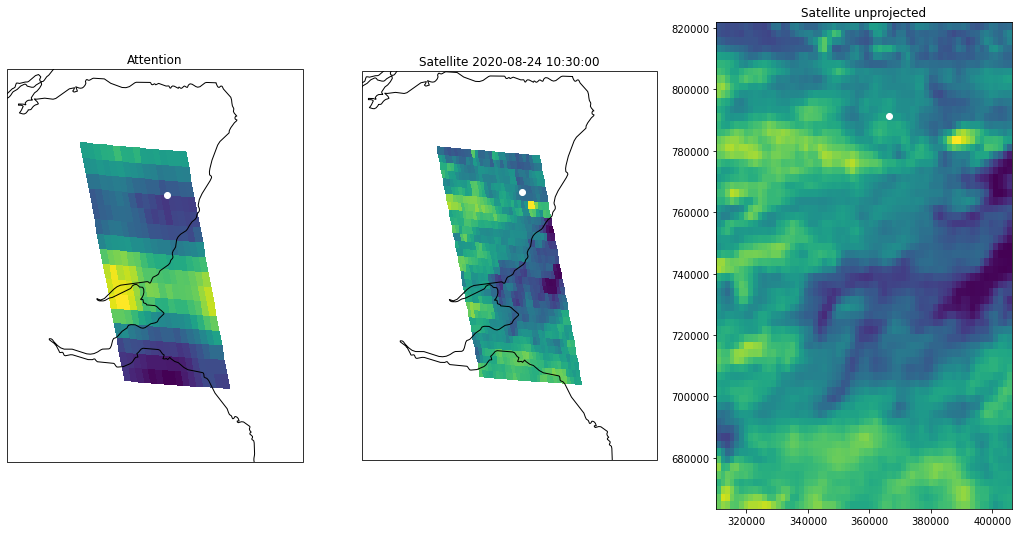

In [25]:
BATCH_IDX = 11
TIMESTEP_IDX = 0
PV_SYSTEM_IDX = 3

projection = ccrs.OSGB(approx=False)

nrows = 1
ncols = 3
shape = (nrows, ncols)

ax1 = plt.subplot2grid(shape, loc=(0, 0), projection=projection)
ax2 = plt.subplot2grid(shape, loc=(0, 1), projection=projection)
ax3 = plt.subplot2grid(shape, loc=(0, 2))

ax1.set_title("Attention")
ax1.pcolormesh(
    batch[BatchKey.hrvsatellite_x_osgb][BATCH_IDX],
    batch[BatchKey.hrvsatellite_y_osgb][BATCH_IDX],
    attn_weights["layer0"][(4*BATCH_IDX)+TIMESTEP_IDX, 256+PV_SYSTEM_IDX][:256].detach().numpy().reshape(16, 16),
    )

date = pd.to_datetime(batch[BatchKey.hrvsatellite_time_utc][BATCH_IDX, TIMESTEP_IDX], unit="s")

ax2.set_title(f"Satellite {date}")

ax2.pcolormesh(
    batch[BatchKey.hrvsatellite_x_osgb][BATCH_IDX].numpy().repeat(4, axis=0).repeat(4, axis=1),
    batch[BatchKey.hrvsatellite_y_osgb][BATCH_IDX].numpy().repeat(4, axis=0).repeat(4, axis=1),
    einops.rearrange(
        batch[BatchKey.hrvsatellite][BATCH_IDX, TIMESTEP_IDX, 0], 
        "y x (patch_size_y patch_size_x) -> (y patch_size_y) (x patch_size_x)",
        patch_size_y=4,
        patch_size_x=4
        ),
)

ax3.set_title("Satellite unprojected")
ax3.imshow(
    einops.rearrange(
        batch[BatchKey.hrvsatellite][BATCH_IDX, TIMESTEP_IDX, 0], 
        "y x (patch_size_y patch_size_x) -> (y patch_size_y) (x patch_size_x)",
        patch_size_y=4,
        patch_size_x=4
        ),
    extent=(
        batch[BatchKey.hrvsatellite_x_osgb][BATCH_IDX][-1, 0],
        batch[BatchKey.hrvsatellite_x_osgb][BATCH_IDX][0, -1],
        batch[BatchKey.hrvsatellite_y_osgb][BATCH_IDX][0, -1],
        batch[BatchKey.hrvsatellite_y_osgb][BATCH_IDX][-1, 0],
    ), # left, right, bottom, top
    origin="lower",
)


for ax in (ax1, ax2, ax3):
    ax.scatter(
        batch[BatchKey.pv_x_osgb][BATCH_IDX, PV_SYSTEM_IDX],
        batch[BatchKey.pv_y_osgb][BATCH_IDX, PV_SYSTEM_IDX],
        color="white",
    )
    
for ax in (ax1, ax2):
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    BORDER_METERS = 50_000
    ax.set_ylim(ylim[0]-BORDER_METERS, ylim[1]+BORDER_METERS)
    ax.set_xlim(xlim[0]-BORDER_METERS, xlim[1]+BORDER_METERS)

    ax.coastlines()

# TODO:
# Plot with OSGB coords
# Overlay coastline so we can see what's what
# Plot location of PV system

In [53]:
batch[BatchKey.hrvsatellite_y_osgb][BATCH_IDX][-1, 0]

tensor(456552.4062)

In [27]:
wandb_logger = WandbLogger(
    project="power_perceiver", 
    entity="openclimatefix",
    log_model="all",
    )

# log gradients, parameter histogram and model topology
wandb_logger.watch(model, log="all")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: openclimatefix (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.13 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [28]:
trainer = pl.Trainer(
    gpus=[5],
    max_epochs=-1,
    logger=wandb_logger,
    callbacks=[
        LogTimeseriesPlots(),
        LogTSNEPlot(),
    ]
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )

/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:342: LightningDeprecationWarning: Base `Callback.on_train_batch_end` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name                   | Type                         | Params
------------------------------------------------------------------------
0 | hrvsatellite_processor | HRVSatelliteProcessor        | 0     
1 | query_generator        | QueryGenerator               | 32.0 K
2 | transformer_encoder    | MultiLayerTransformerEncoder | 620 K 
3 | output_module          | Sequential                   | 1.4 K 
------------------------------------------------------------------------
653 K     Trainable params
0         Non-trainable params
653 K     Total params
2.614     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                             | 0/2 [00:01<?, ?it/s]

/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Epoch 0:   0%|                                                                               | 0/8800 [00:00<?, ?it/s]

/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Epoch 0:  33%|██████████████                             | 2875/8800 [02:25<05:00, 19.71it/s, loss=0.0168, v_num=f7k5]